In [16]:
# !nvcc -O3 -std=c++20 -Xcompiler "-march=native -mtune=native -pipe -fvisibility=hidden -fno-strict-aliasing -funroll-loops -ffast-math -fomit-frame-pointer -Wall -fopenmp -fPIC" -I/home/Robert/Code/Python/F1-ATPase-simulation/Python-3.11.8-build/include/python3.11 -I/home/Robert/Code/Python/F1-ATPase-simulation/data-Sim_env_linux/lib/python3.11/site-packages/pybind11/include src/core/cpp/LangevinGillespie.cu src/core/cuda/simulate_multithreaded.cu -o src/core/cpp/f1sim.cpython-311-x86_64-linux-gnu.so -shared -lcudart -L/usr/local/cuda/lib64


In [17]:
from src.utils.compute_transition_matrix import compute_transition_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from f1sim import LangevinGillespie


<hr>

### Initial Simulation Setup (Currently Supports 4 States)


In [18]:
# Simulation Setup
LG = LangevinGillespie()
LG.steps = 2000
LG.dt = 1e-6
LG.method = "heun"

# Mechanical / Thermal Setup
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a=20, r=19, eta=1e-9)

# Multi State Setup
LG.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG.initial_state = 0  # Starting state

# Transition rate matrix
LG.transition_matrix = compute_transition_matrix(LG)

angles, states, thetas = LG.simulate()

In [19]:
deg_factor = 180 / math.pi
for i in range(len(angles)):
    angles[i] *= deg_factor  # Convert to degrees
    thetas[i] *= deg_factor  # Convert to degrees

<hr>

### Initial Simulation Results


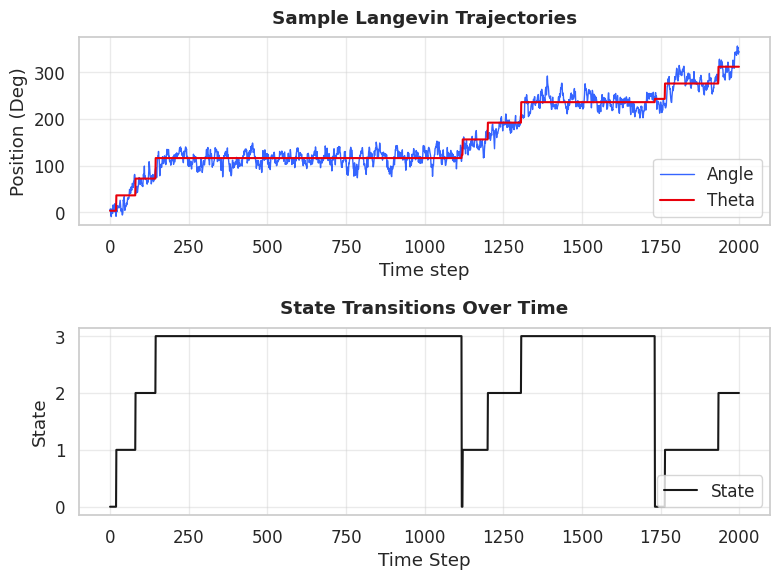

In [20]:
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.1)
plt.figure(figsize=(8, 6))

# Top subplot
plt.subplot(2, 1, 1)
plt.plot(angles, color="b", alpha=0.8, linewidth=1, linestyle="-", label="Angle")
plt.plot(thetas, color="r", alpha=1, linewidth=1.5, linestyle="-", label="Theta")
plt.grid(True, alpha=0.4)
plt.xlabel("Time step")
plt.ylabel("Position (Deg)")
plt.title("Sample Langevin Trajectories", pad=10, weight="bold")
plt.legend(loc="lower right", frameon=True)

# Bottom subplot
plt.subplot(2, 1, 2)
plt.plot(states, color="black", alpha=0.9, linewidth=1.5, linestyle="-", label="State")
plt.ylabel("State")
plt.xlabel("Time Step")
plt.title("State Transitions Over Time", pad=10, weight="bold")
plt.grid(True, alpha=0.4)
plt.yticks(np.arange(len(LG.theta_states)))
plt.legend(loc="lower right", frameon=True)

plt.tight_layout()


<hr>

### Simulation PDF

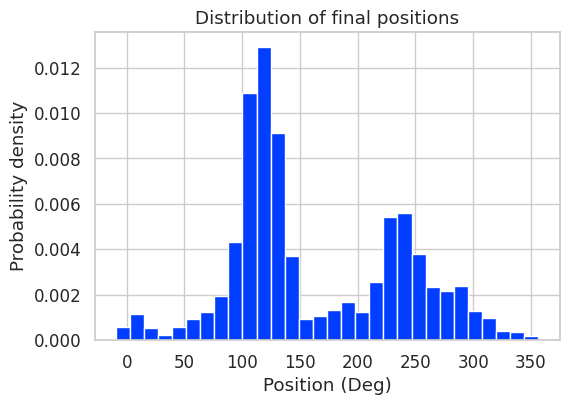

In [21]:
plt.figure(figsize=(6, 4))
plt.hist(angles, bins=30, density=True)
plt.xlabel("Position (Deg)")
plt.ylabel("Probability density")
plt.title("Distribution of final positions");

<hr>

### Four Simulations, each starting at a differing state


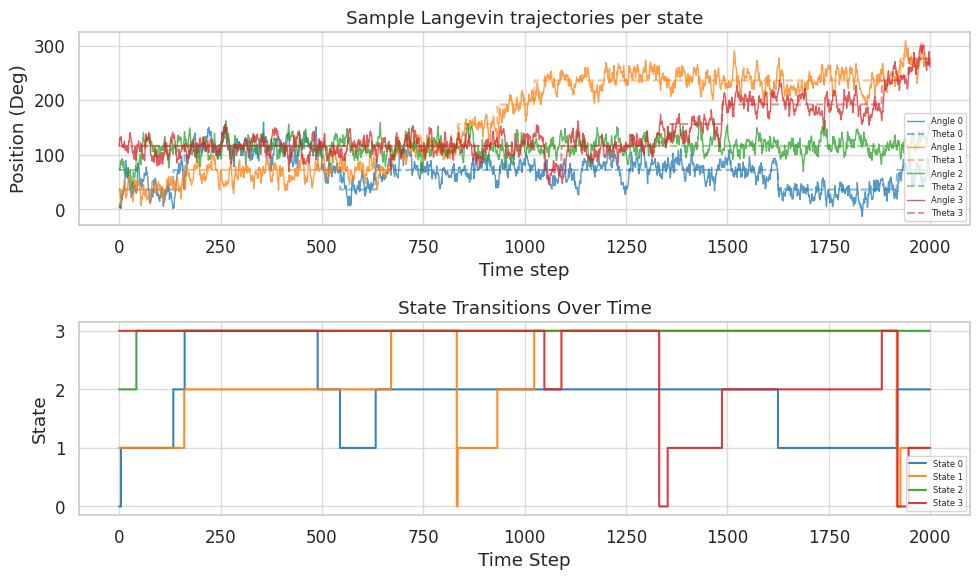

In [22]:
# Multi Simulation, starting at each state
all_angles = []
all_thetas = []
all_states = []

num_states = 4
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Simulate 4 times, each starting at a differing state from our theta_states array
for state in range(num_states):
    LG.initial_state = state
    angles_data, states_data, thetas_data = LG.simulate()
    for i in range(len(angles)):
        angles_data[i] *= deg_factor  # Convert to degrees
        thetas_data[i] *= deg_factor  # Convert to degrees
    all_angles.append(angles_data)
    all_thetas.append(thetas_data)
    all_states.append(states_data)

all_angles = np.array(all_angles)
all_thetas = np.array(all_thetas)
all_states = np.array(all_states)

# Plot all simulations
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
for state in range(num_states):
    plt.plot(
        all_angles[state],
        color=colors[state],
        alpha=0.75,
        linewidth=1,
        label=f"Angle {state}",
    )
    plt.plot(
        all_thetas[state],
        linestyle="--",
        color=colors[state],
        alpha=0.5,
        linewidth=1.5,
        label=f"Theta {state}",
    )


plt.grid(True, alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Position (Deg)")
plt.title("Sample Langevin trajectories per state")
plt.legend(loc="lower right", fontsize=6)

plt.subplot(2, 1, 2)
for state in range(num_states):
    plt.step(
        range(len(all_states[state])),
        all_states[state],
        where="mid",
        color=colors[state],
        alpha=0.9,
        linewidth=1.5,
        label=f"State {state}",
    )

plt.ylabel("State")
plt.xlabel("Time Step")
plt.title("State Transitions Over Time")
plt.grid(True, alpha=0.7)
plt.yticks(np.arange(len(LG.theta_states)))
plt.legend(loc="lower right", fontsize=6)

plt.tight_layout()

<hr>

### Thread Support

In [23]:
MAX_THREAD_COUNT = 32
SIMULATION_COUNT = 32

In [24]:
# Threads are implemented in CPP in order to remove GIL restrictions
combined_bead_positions, combined_states, combined_target_thetas = (
    LG.simulate_multithreaded(SIMULATION_COUNT, MAX_THREAD_COUNT)
)

In [25]:
combined_bead_positions = np.array(combined_bead_positions, dtype=float)
combined_target_thetas = np.array(combined_target_thetas, dtype=float)
combined_states = np.array(combined_states, dtype=float)

combined_bead_positions *= deg_factor
combined_target_thetas *= deg_factor

# Turn the 2D matrix into a vector
combined_bead_positions = np.vstack([np.array(b) for b in combined_bead_positions]).T
combined_target_thetas = np.vstack([np.array(t) for t in combined_target_thetas]).T

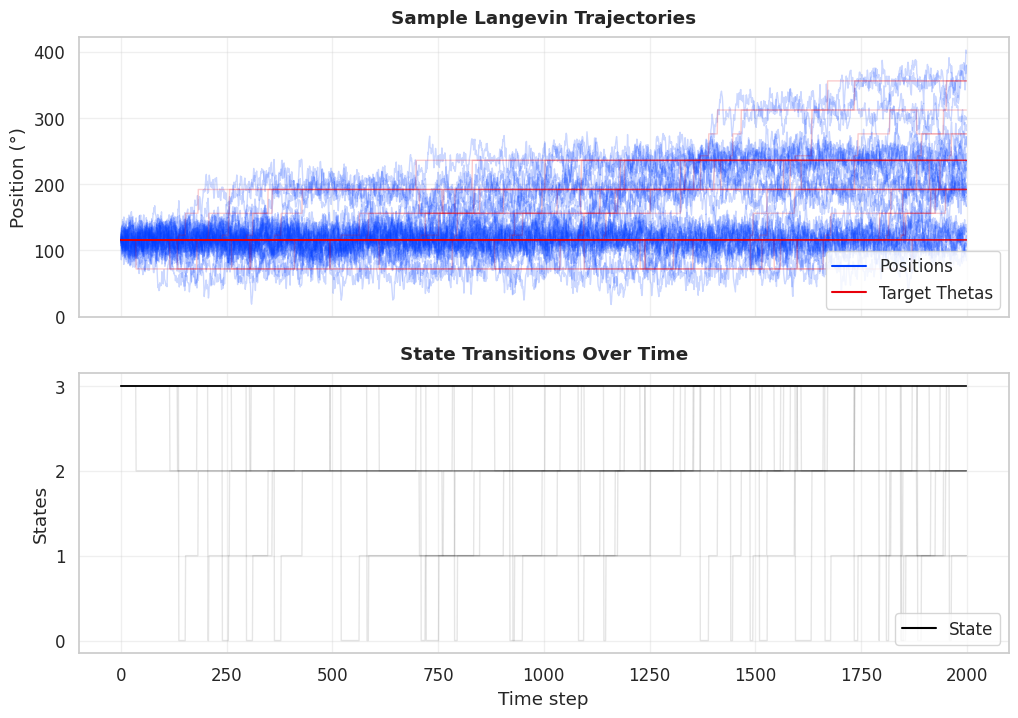

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(combined_bead_positions, color="b", alpha=0.2, linewidth=1)
axs[0].plot([], [], color="b", label="Positions")
axs[0].legend(loc="lower right", frameon=True)
axs[0].plot(np.array(combined_target_thetas), color="r", alpha=0.2, linewidth=1)

axs[0].plot([], [], color="r", label="Target Thetas")
axs[0].set_title("Sample Langevin Trajectories", pad=10, weight="bold")
axs[0].set_ylabel("Position (°)")
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc="lower right", frameon=True)

for state_group in combined_states:
    axs[1].plot(np.array(state_group).T, color="black", alpha=0.1, linewidth=1)

axs[1].set_title("State Transitions Over Time", pad=10, weight="bold")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("States")
axs[1].grid(True, alpha=0.3)
axs[1].set_yticks(np.arange(len(LG.theta_states)))
axs[1].plot([], [], color="black", label="State")
axs[1].legend(loc="lower right", frameon=True);

<hr>

## Cuda Support

In [ ]:
SIMULATION_COUNT_CUDA = 50

In [28]:
# Threads are implemented in CPP in order to remove GIL restrictions
combined_bead_positions, combined_states, combined_target_thetas = (
    LG.simulate_multithreaded_cuda(SIMULATION_COUNT_CUDA)
)

In [29]:
combined_bead_positions = np.array(combined_bead_positions, dtype=float)
combined_target_thetas = np.array(combined_target_thetas, dtype=float)
combined_states = np.array(combined_states, dtype=float)

combined_bead_positions *= deg_factor
combined_target_thetas *= deg_factor

# Turn the 2D matrix into a vector
combined_bead_positions = np.vstack([np.array(b) for b in combined_bead_positions]).T
combined_target_thetas = np.vstack([np.array(t) for t in combined_target_thetas]).T

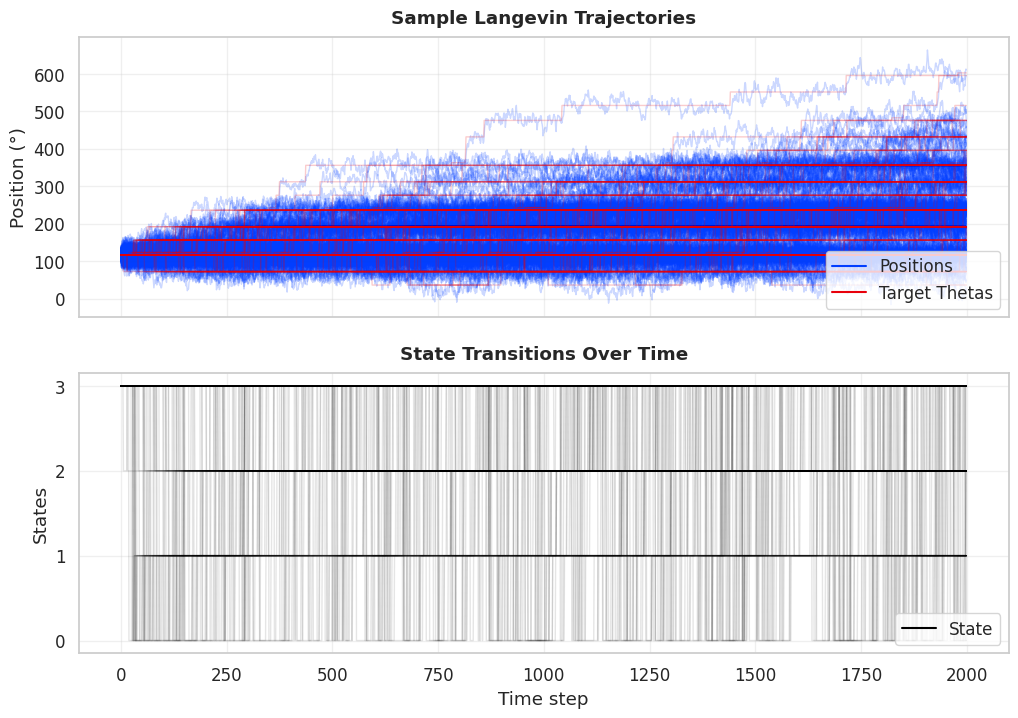

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(combined_bead_positions, color="b", alpha=0.2, linewidth=1)
axs[0].plot([], [], color="b", label="Positions")
axs[0].legend(loc="lower right", frameon=True)
axs[0].plot(np.array(combined_target_thetas), color="r", alpha=0.2, linewidth=1)

axs[0].plot([], [], color="r", label="Target Thetas")
axs[0].set_title("Sample Langevin Trajectories", pad=10, weight="bold")
axs[0].set_ylabel("Position (°)")
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc="lower right", frameon=True)

for state_group in combined_states:
    axs[1].plot(np.array(state_group).T, color="black", alpha=0.1, linewidth=1)

axs[1].set_title("State Transitions Over Time", pad=10, weight="bold")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("States")
axs[1].grid(True, alpha=0.3)
axs[1].set_yticks(np.arange(len(LG.theta_states)))
axs[1].plot([], [], color="black", label="State")
axs[1].legend(loc="lower right", frameon=True);